In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import torch
from torchmetrics.regression import MeanAbsoluteError
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('./data/daily_min_temp.csv')
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


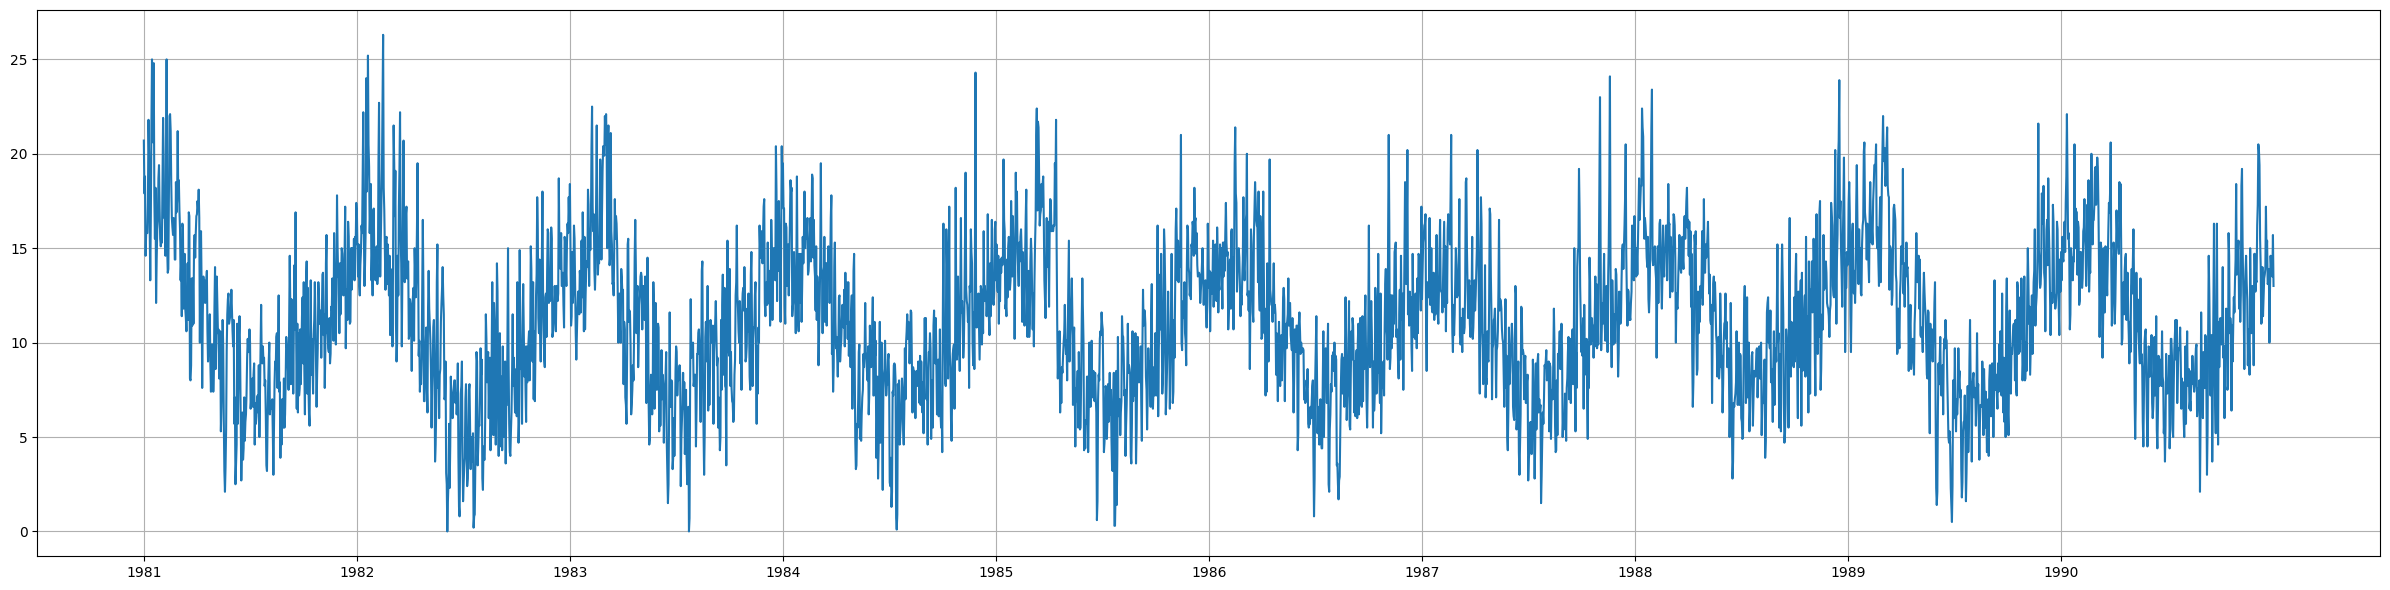

In [3]:
ax = df.Temp.plot( grid=True, figsize=(24,6))
ax.set_xticks(np.arange(0,3649, 365), np.arange(1981, 1991, 1))
plt.tight_layout()

In [106]:
df.Temp.min(), df.Temp.max()

(0.0, 26.3)

In [4]:
df.columns = ['ds', 'y']
train = df[:-365]
test = df[-365:]

In [113]:
train.shape

(3285, 2)

In [5]:
m = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=0.01)

In [6]:
m.fit(train)

12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

In [183]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_92268/1319008201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]


,ds,y,yhat,yhat_lower,yhat_upper,baseline
3285,1990-01-01,14.8,14.676934,10.971992,18.076102,14.3
3286,1990-01-02,13.3,14.799227,11.418603,18.488859,17.4
3287,1990-01-03,15.6,14.874286,11.219256,18.327948,18.5
3288,1990-01-04,14.5,14.792902,11.435278,18.428534,16.8
3289,1990-01-05,14.3,14.862070,11.198565,18.236733,11.5


In [184]:
test.shape

(365, 6)

In [185]:
test['baseline'] = train['y'][-365:].values
test.head()

/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_92268/2898932684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['baseline'] = train['y'][-365:].values


,ds,y,yhat,yhat_lower,yhat_upper,baseline
3285,1990-01-01,14.8,14.676934,10.971992,18.076102,14.3
3286,1990-01-02,13.3,14.799227,11.418603,18.488859,17.4
3287,1990-01-03,15.6,14.874286,11.219256,18.327948,18.5
3288,1990-01-04,14.5,14.792902,11.435278,18.428534,16.8
3289,1990-01-05,14.3,14.862070,11.198565,18.236733,11.5


In [186]:
mean_absolute_error = MeanAbsoluteError()

maes = {}

baseline = torch.FloatTensor( test['baseline'].values)
yhat = torch.FloatTensor( test['yhat'].values)
actual = torch.FloatTensor(test['y'].values)


maes['baseline'] =  mean_absolute_error( baseline, actual ).item()
maes['yhat'] = mean_absolute_error( yhat, actual ).item()
maes

{'baseline': 2.8673973083496094, 'yhat': 1.928006887435913}

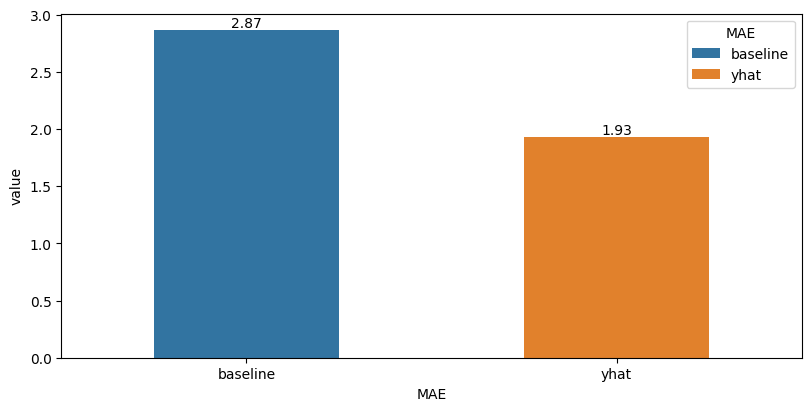

In [187]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

(3200.0, 3649.0)

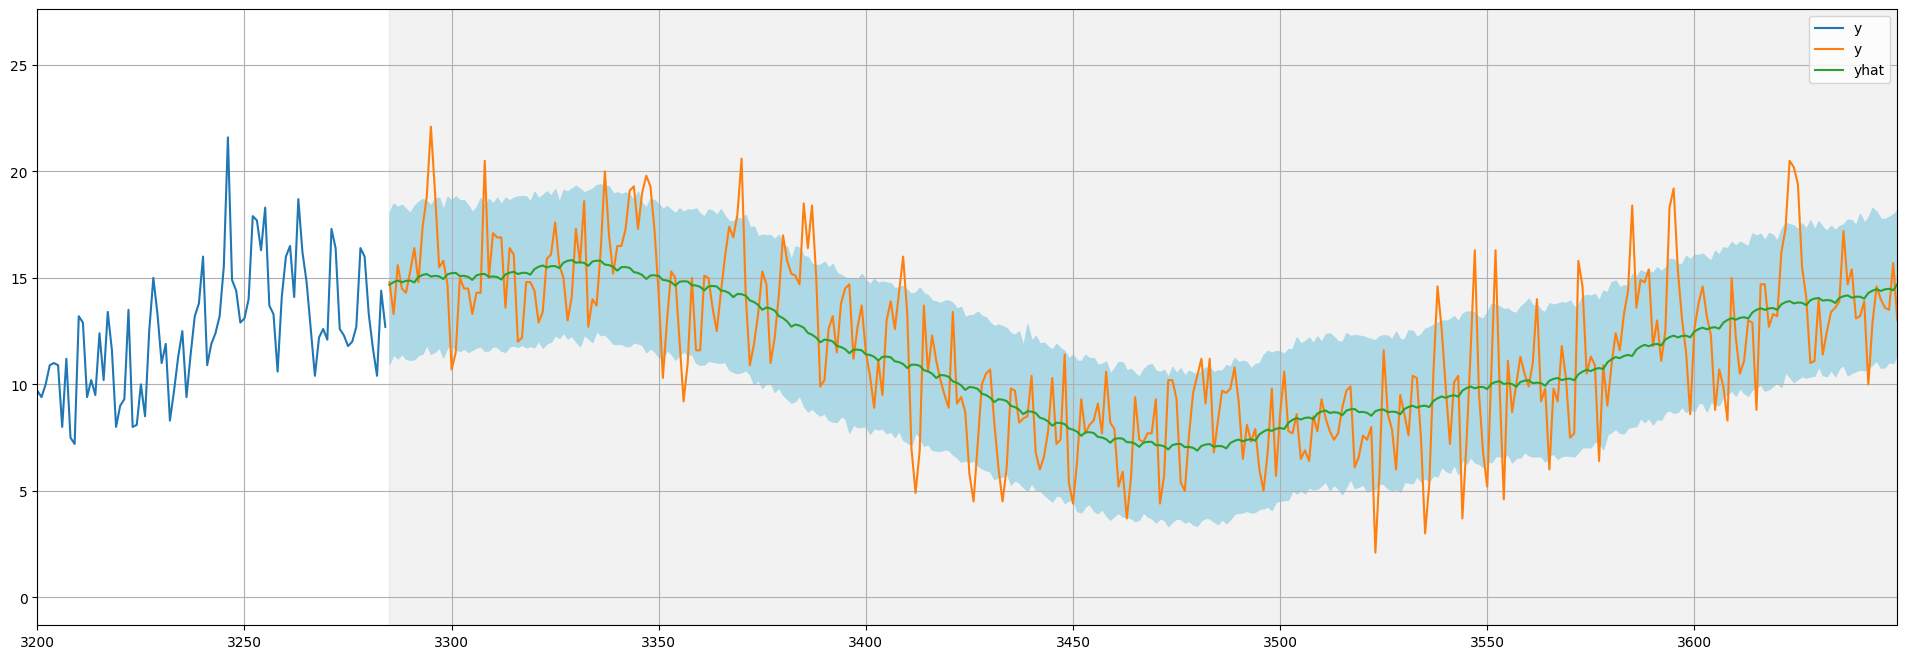

In [188]:
ax = train.plot( figsize=(16,4),  layout='constrained' )
test[['y', 'yhat']].plot(grid=True, figsize=(24,8), ax=ax)
ax.axvspan(3285, 3649, color='#808080', alpha=0.1)
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(3200, 3649)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


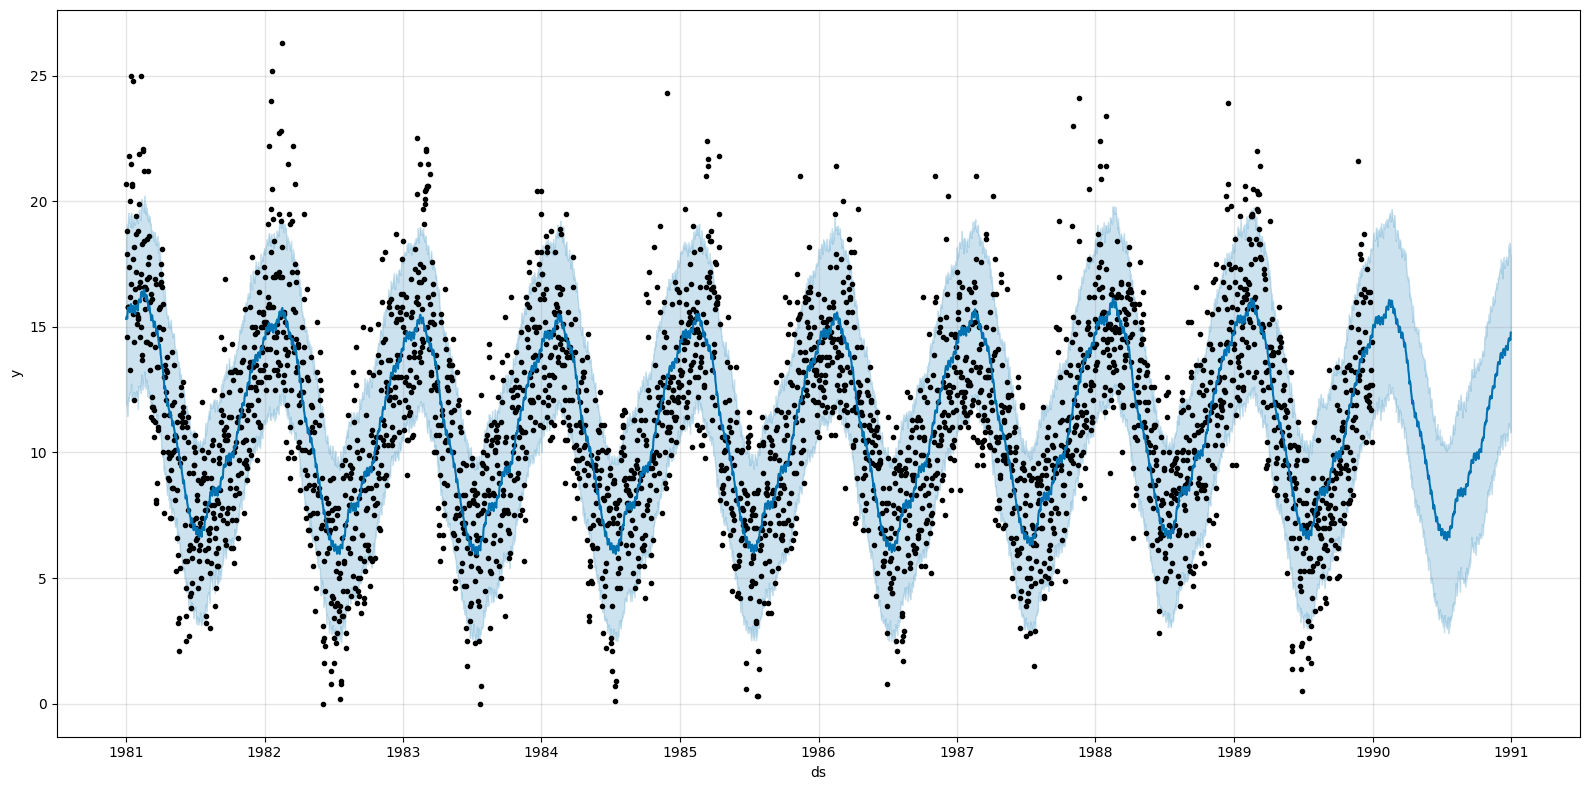

In [137]:
fig1 = m.plot(forecast, figsize=(16,8))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

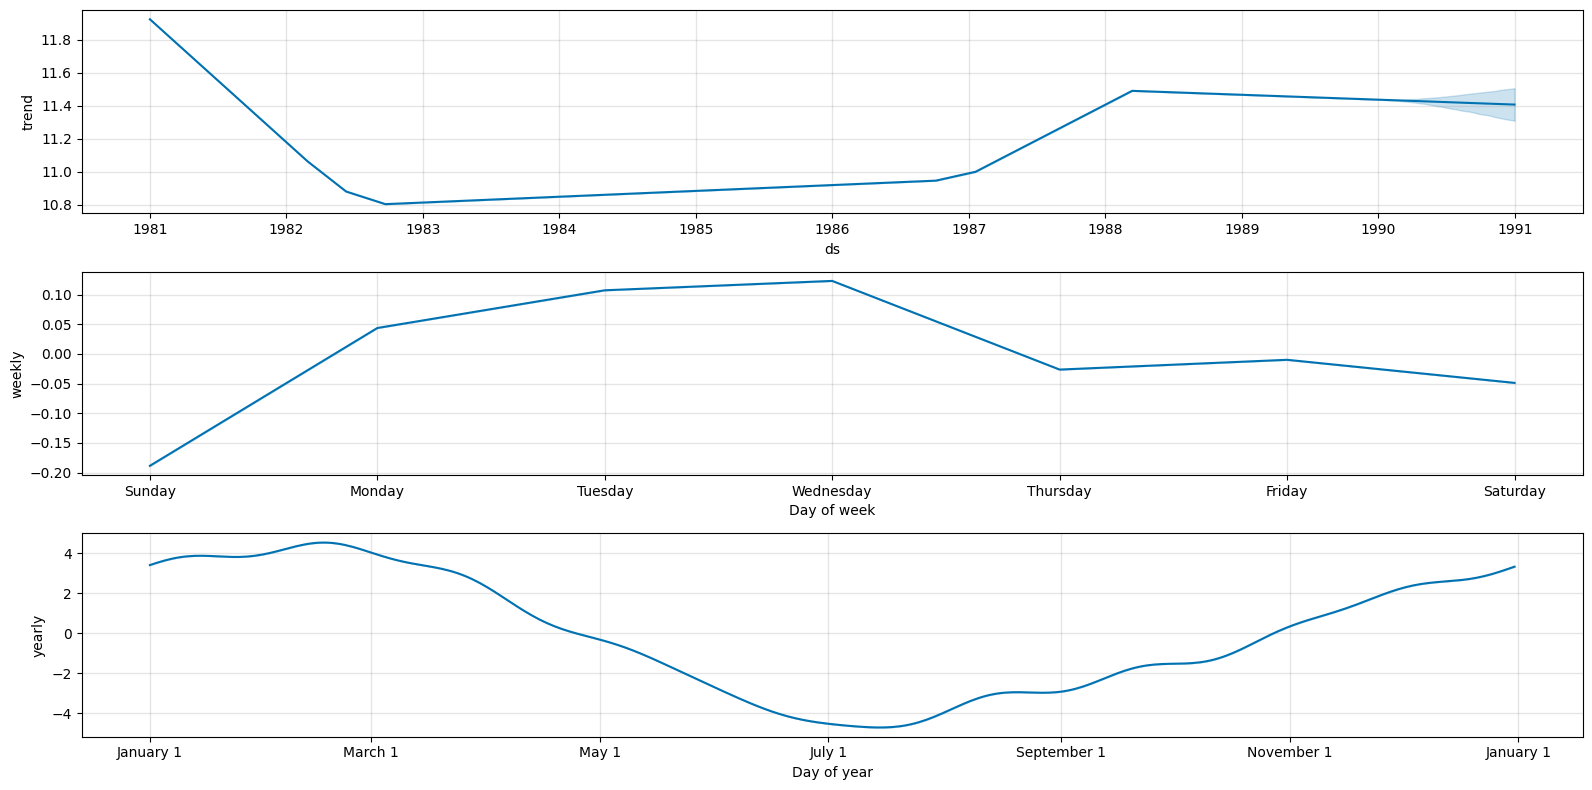

In [136]:
fig2 = m.plot_components(forecast, figsize=(16,8))

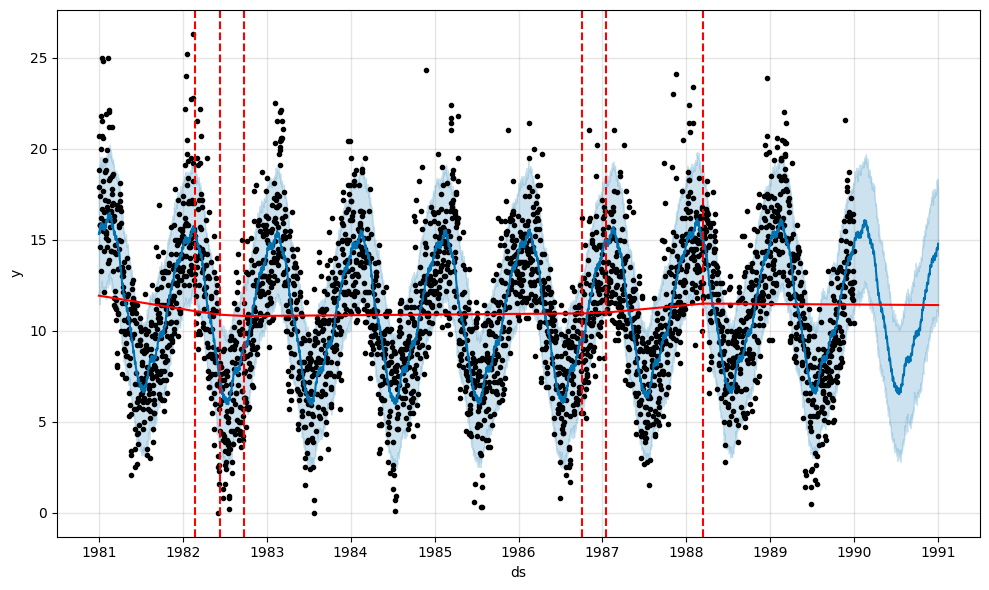

In [142]:
from prophet.plot import add_changepoints_to_plot

fig3 = m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],


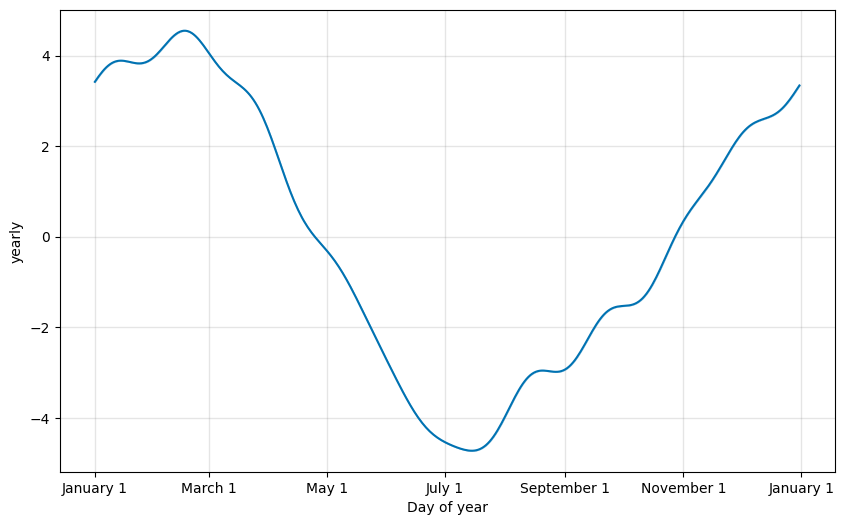

In [148]:
from prophet.plot import plot_yearly

fig4 = plot_yearly(m)

11:51:46 - cmdstanpy - INFO - Chain [1] start processing
11:51:46 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],


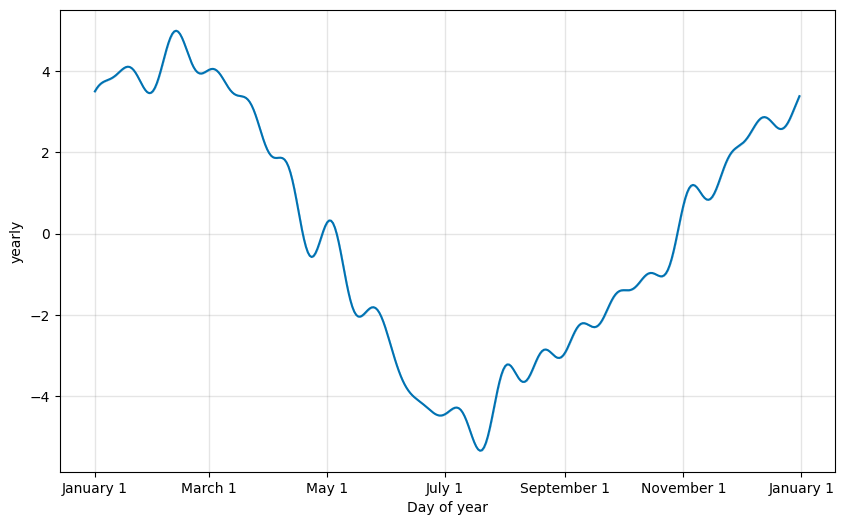

In [149]:
m2 = Prophet(yearly_seasonality=20).fit(train)

fig6 = plot_yearly(m2)


In [ ]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

In [153]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1983-02-02,15.180760,11.983749,18.982159,17.3,1983-02-01
1,1983-02-03,14.843227,11.221185,18.182341,13.0,1983-02-01
2,1983-02-04,15.238653,11.744352,18.620029,16.0,1983-02-01
3,1983-02-05,15.230166,11.584047,18.932308,14.9,1983-02-01
4,1983-02-06,15.277526,11.829208,18.956482,16.2,1983-02-01


In [152]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
4736,1989-12-27,16.147386,12.850155,19.867167,13.3,1988-12-31
4737,1989-12-28,16.049448,12.417688,19.622369,11.7,1988-12-31
4738,1989-12-29,16.163609,12.467740,19.744682,10.4,1988-12-31
4739,1989-12-30,16.198463,12.552581,19.737139,14.4,1988-12-31
4740,1989-12-31,16.117518,12.666676,19.941114,12.7,1988-12-31


In [173]:


df_perf = performance_metrics(df_cv, rolling_window=0)

df_perf.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,6.343070,2.518545,2.070920,0.150126,0.198579,0.846154
1,2 days,4.688372,2.165265,1.746947,0.141787,0.161501,0.846154
2,3 days,10.002355,3.162650,2.657245,0.146937,0.371581,0.769231
3,4 days,8.643322,2.939953,2.374467,0.195721,0.328718,0.769231
4,5 days,8.195715,2.862816,2.560727,0.195882,0.300317,0.692308


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


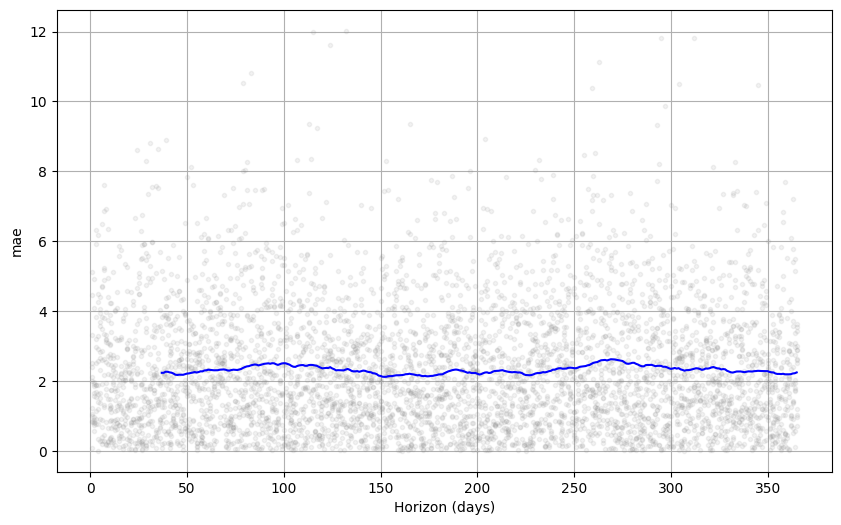

In [155]:
from prophet.plot import plot_cross_validation_metric

fig7 = plot_cross_validation_metric(df_cv, metric='mae')

In [8]:
from itertools import product

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

In [ ]:

maes = []

for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    maes.append(df_p['mae'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

In [16]:
tuning_results.sort_values(['mae']).head(1)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,mae
19,0.01,0.01,10.0,2.240415


In [17]:
df_chocolate = pd.read_csv('./data/monthly_chocolate_search_usa.csv')
df_chocolate

,month,chocolate
0,2004-01,35
1,2004-02,48
2,2004-03,34
3,2004-04,33
4,2004-05,33
...,...,...
211,2021-08,45
212,2021-09,45
213,2021-10,44
214,2021-11,54


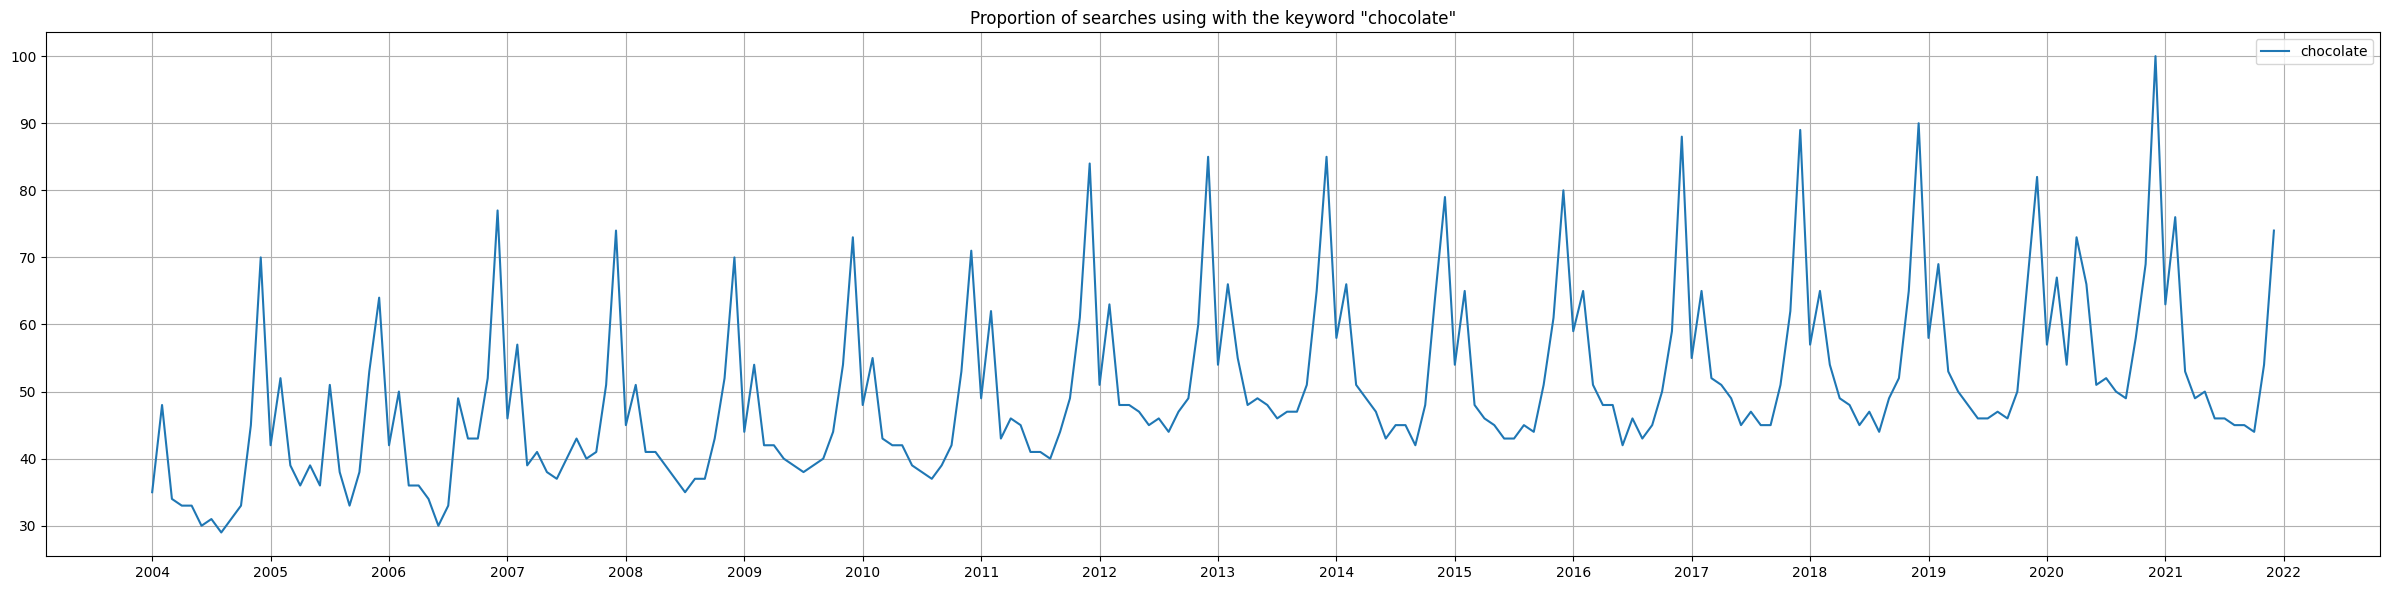

In [18]:
ax = df_chocolate.plot(grid=True, figsize=(24,6))
ax.set_xticks(np.arange(0,227,12), np.arange(2004,2023, 1))
ax.set_title('Proportion of searches using with the keyword "chocolate"')
plt.tight_layout()

In [19]:
df_chocolate.columns = ['ds', 'y']
df_chocolate

,ds,y
0,2004-01,35
1,2004-02,48
2,2004-03,34
3,2004-04,33
4,2004-05,33
...,...,...
211,2021-08,45
212,2021-09,45
213,2021-10,44
214,2021-11,54


In [20]:
from pandas.tseries.offsets import MonthEnd

df_chocolate['ds'] = pd.to_datetime(df_chocolate['ds']) + MonthEnd(1)

df_chocolate.head()

,ds,y
0,2004-01-31,35
1,2004-02-29,48
2,2004-03-31,34
3,2004-04-30,33
4,2004-05-31,33


In [21]:
train_chocolate = df_chocolate[:-12]
test_chocolate = df_chocolate[-12:]

In [22]:
test_chocolate.head(1)

,ds,y
204,2021-01-31,63


In [23]:
train_chocolate.head(), train_chocolate.tail()

(          ds   y
 0 2004-01-31  35
 1 2004-02-29  48
 2 2004-03-31  34
 3 2004-04-30  33
 4 2004-05-31  33,
             ds    y
 199 2020-08-31   50
 200 2020-09-30   49
 201 2020-10-31   58
 202 2020-11-30   69
 203 2020-12-31  100)

In [24]:
cutoffs = pd.date_range(start='2008-12-31', end='2019-12-31', freq='12ME')
cutoffs

DatetimeIndex(['2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31'],
              dtype='datetime64[ns]', freq='12ME')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

mses_chocolate = []

for param in all_params:
    m = Prophet(**param)
    m.add_country_holidays(country_name='US')
    m.fit(train_chocolate)
    
    df_cv = cross_validation(model=m,   horizon='365 days',cutoffs=cutoffs,  parallel='processes' )
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    mses_chocolate.append(df_p['mse'].values[0])


In [26]:
    
tuning_results_chocolate = pd.DataFrame(all_params)
tuning_results_chocolate['mse'] = mses_chocolate
tuning_results_chocolate.sort_values(['mse']).head(1)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,mse
6,0.001,0.1,1.0,14.469302


In [ ]:
m = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, holidays_prior_scale= 1.0)
m.add_country_holidays(country_name='US')
m.fit(train_chocolate)


In [28]:
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
204,2021-01-31,60.701639,56.166728,65.143153
205,2021-02-28,69.869908,65.215482,74.515992
206,2021-03-31,56.216523,51.850684,60.670640
207,2021-04-30,56.200532,51.836003,60.376126
208,2021-05-31,53.497643,49.154623,58.102364
209,2021-06-30,51.193096,46.392200,55.844381
210,2021-07-31,52.957764,48.899338,57.887549
211,2021-08-31,52.523985,48.445177,57.171680
212,2021-09-30,52.631717,48.418612,57.175887
213,2021-10-31,56.945337,52.533181,61.850708


In [29]:
test_chocolate[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test_chocolate

,ds,y,yhat,yhat_lower,yhat_upper
204,2021-01-31,63,60.701639,56.166728,65.143153
205,2021-02-28,76,69.869908,65.215482,74.515992
206,2021-03-31,53,56.216523,51.850684,60.670640
207,2021-04-30,49,56.200532,51.836003,60.376126
208,2021-05-31,50,53.497643,49.154623,58.102364
209,2021-06-30,46,51.193096,46.392200,55.844381
210,2021-07-31,46,52.957764,48.899338,57.887549
211,2021-08-31,45,52.523985,48.445177,57.171680
212,2021-09-30,45,52.631717,48.418612,57.175887
213,2021-10-31,44,56.945337,52.533181,61.850708


In [30]:
test_chocolate['baseline'] = train_chocolate['y'][-12:].values
test_chocolate

,ds,y,yhat,yhat_lower,yhat_upper,baseline
204,2021-01-31,63,60.701639,56.166728,65.143153,57
205,2021-02-28,76,69.869908,65.215482,74.515992,67
206,2021-03-31,53,56.216523,51.850684,60.670640,54
207,2021-04-30,49,56.200532,51.836003,60.376126,73
208,2021-05-31,50,53.497643,49.154623,58.102364,66
209,2021-06-30,46,51.193096,46.392200,55.844381,51
210,2021-07-31,46,52.957764,48.899338,57.887549,52
211,2021-08-31,45,52.523985,48.445177,57.171680,50
212,2021-09-30,45,52.631717,48.418612,57.175887,49
213,2021-10-31,44,56.945337,52.533181,61.850708,58


In [31]:
mean_absolute_error = MeanAbsoluteError()

maes = {}

baseline = torch.FloatTensor( test_chocolate['baseline'].values)
predict = torch.FloatTensor( test_chocolate['yhat'].values)
actual = torch.FloatTensor(test_chocolate['y'].values)


maes['baseline'] =  mean_absolute_error( baseline, actual ).item()
maes['predict'] = mean_absolute_error( predict, actual ).item()
maes

{'baseline': 10.916666984558105, 'predict': 7.467379093170166}

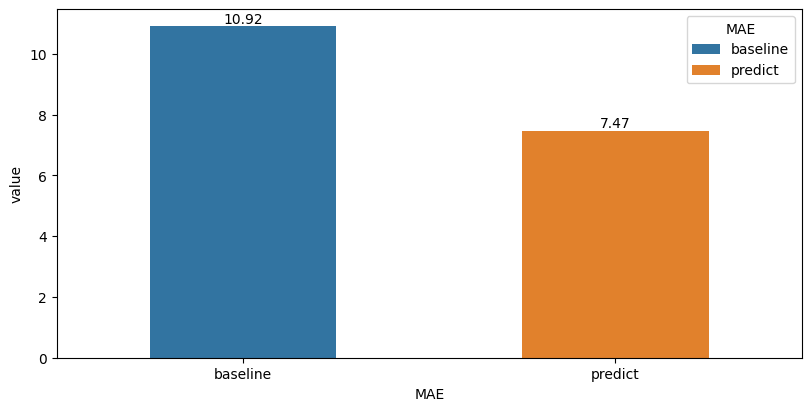

In [32]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

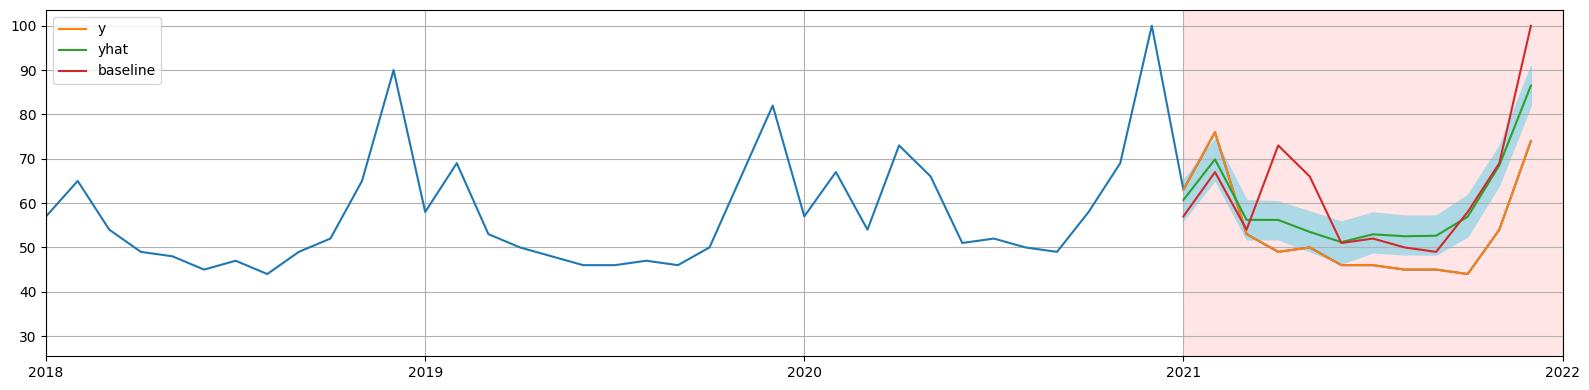

In [33]:
ax = df_chocolate.y.plot( figsize=(16,4))
ax.set_xticks(np.arange(0,227,12), np.arange(2004,2023, 1))
ax.axvspan(204, 216, facecolor='red', alpha=0.1)
ax.set_xlim(168, 216)


test_chocolate[['y','yhat', 'baseline']].plot( ax = ax)

plt.fill_between(x=test_chocolate.index, y1=test_chocolate['yhat_lower'], y2=test_chocolate['yhat_upper'], color='lightblue')
ax.grid()
plt.tight_layout()

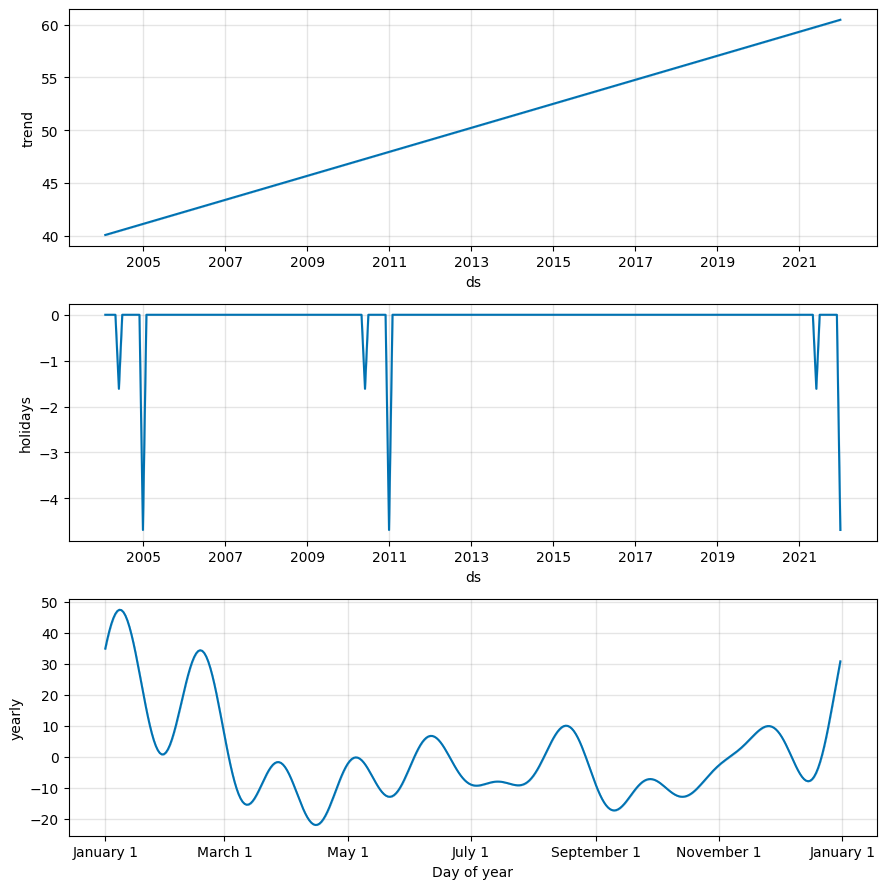

In [34]:
prophet_components_fig = m.plot_components(forecast)